# Logistic Regression Problem Formulation

### 1. Goal
> Predict whether a car is **American-made** (`origin = 1`) or **foreign-made** (`origin = 2 or 3`) using its technical specifications.

### 2. Problem Statement
> We want to classify cars as either American or foreign based on features such as `cylinders`, `displacement`, `horsepower`, `weight`, and `acceleration`. This is a binary classification task where the target variable is derived from the `origin` column.

### 3. Target Variable
- Original column: `origin`
- Transformed binary label:
  - `1` → American-made
  - `0` → Foreign-made (Europe or Japan)

### 4. Input Features
- `cylinders`
- `displacement`
- `horsepower`
- `weight`
- `acceleration`

These reflect that engine size, power, and design choices may differ by region.

### 5. Hypotheses
- **Null Hypothesis (H₀)**: None of the selected features significantly influence whether a car is American-made. All coefficients are zero.
- **Alternative Hypothesis (H₁)**: At least one of the selected features significantly influences the likelihood that a car is American-made.

### 6. Example Input
```csv
cylinders, displacement, horsepower, weight, acceleration
4,113,95,2372,15
```

### 7. Predicted Output
```csv
0 → Foreign-made
```

## The expected approach involves:

1. Formulating the Model: Defining the linear combination of features and the sigmoid function.

2. Using Gradient Descent: This is the standard optimization algorithm used to train the Logistic Regression model (just as it is used to train DNNs).

3. Using the Sigmoid Function: This is the link function that maps the linear output to a probability between 0 and 1.

4. Using the Log-Loss (Cross-Entropy) Function: This is the standard cost function for classification tasks like this.

In [1]:
import pandas as pd

# Load the dataset
original_data = pd.read_csv("cars.csv")

# Clean the data (Removes the rows with '?')
data = original_data[original_data['horsepower'] != '?'].copy()

# 2. Convert to numeric (as they were stored as object since pd.read_csv() because of the '?')
data['horsepower'] = pd.to_numeric(data['horsepower'])

# Create a new binary column based on the rule
# This sets the new column to 1 (True) wherever 'origin' is 1
# And 0 (False) otherwise. Pandas/NumPy automatically converts True/False to 1/0.
data['origin_binary'] = (data['origin'] == 1).astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mpg            392 non-null    float64
 1   cylinders      392 non-null    int64  
 2   displacement   392 non-null    float64
 3   horsepower     392 non-null    int64  
 4   weight         392 non-null    int64  
 5   acceleration   392 non-null    float64
 6   model year     392 non-null    int64  
 7   origin         392 non-null    int64  
 8   car name       392 non-null    object 
 9   origin_binary  392 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 33.7+ KB


In [5]:
from sklearn.model_selection import train_test_split

# Assuming 'data' DataFrame exists and 'origin_binary' is created
feature_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']
target_col = 'origin_binary'

X = data[feature_cols].values
y = data[target_col].values

# First Split: Separate out the Test set (15%)
# Using train_test_split for automatic shuffling of data before splitting
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Second Split: Separate the remaining data (X_temp) into Train (70%) and Validation (15%)
# Since X_temp is 85% of the original data, 15% of the original data is 
# approximately (0.15 / 0.85) of X_temp, which is ~0.176.
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=(0.15 / 0.85), random_state=42
)

# Check sizes (will be close to 70/15/15)
print(f"Train size: {len(X_train)} ({len(X_train)/len(X):.2f})")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X):.2f})")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X):.2f})")
X_train


Train size: 274 (0.70)
Validation size: 59 (0.15)
Test size: 59 (0.15)


array([[4.000e+00, 9.700e+01, 8.800e+01, 2.100e+03, 1.650e+01],
       [6.000e+00, 2.250e+02, 1.000e+02, 3.233e+03, 1.540e+01],
       [4.000e+00, 1.400e+02, 7.500e+01, 2.542e+03, 1.700e+01],
       ...,
       [8.000e+00, 4.000e+02, 1.900e+02, 4.422e+03, 1.250e+01],
       [8.000e+00, 3.500e+02, 1.800e+02, 4.499e+03, 1.250e+01],
       [4.000e+00, 7.800e+01, 5.200e+01, 1.985e+03, 1.940e+01]],
      shape=(274, 5))

In [6]:
# Apply scaling and bias
from sklearn.preprocessing import StandardScaler
import numpy as np 

# --- Feature Scaling ---
scaler = StandardScaler()

# 1. Fit the scaler ONLY on the training data.
scaler.fit(X_train)

# 2. Transform ALL three sets using the training set's statistics.
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Bias Term Addition ---

# Add a column of ones (value 1) at index 0 (the first column) to the SCALED data.
# The 'axis=1' ensures the column is added horizontally.
X_train_final = np.insert(X_train_scaled, 0, 1, axis=1)
X_val_final = np.insert(X_val_scaled, 0, 1, axis=1)
X_test_final = np.insert(X_test_scaled, 0, 1, axis=1)

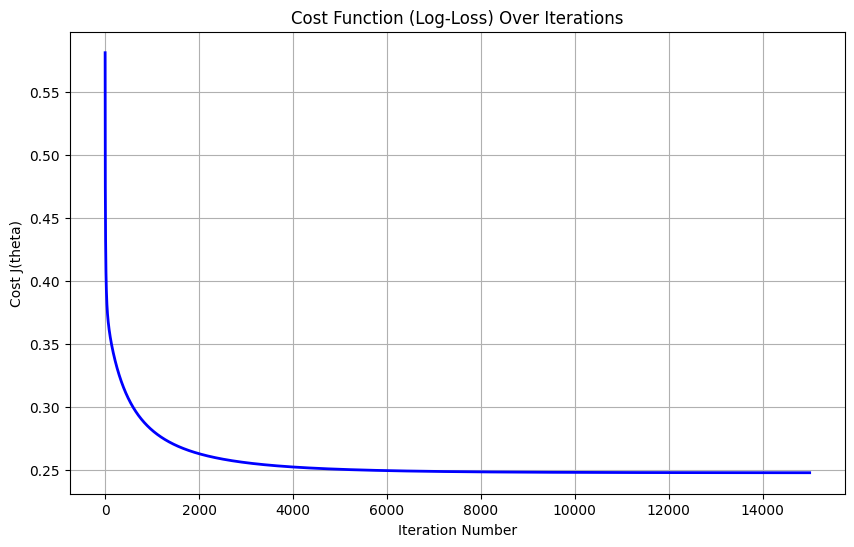

In [53]:
# Replace h2 with the Logistic Regression Hypothesis (Sigmoid)
def h_log(theta, X):
    # Ensure X includes a column of ones for the bias term (theta[0])
    # The linear score 'z' is the dot product of X and theta
    z = X.dot(theta.T)
    # Return the sigmoid function of z, which gives the predicted probability
    return 1 / (1 + np.exp(-z))

# Replace linear_cost_prime with the Logistic Regression Gradient
def logistic_cost_prime(h_log, theta, X, y):
    m = len(y)
    # Calculate the prediction (h_log(theta, X))
    predictions = h_log(theta, X)
    # Calculate the 'error' (prediction - actual)
    error = predictions - y
    
    # The gradient is (1/m) * (error . X)
    # X.T.dot(error) performs the summation for all features simultaneously
    delta = (1/m) * X.T.dot(error)
    
    # Note: X.T.dot(error) returns a vector, no need for the complex loop 
    # structure you had in the 1D example.
    return delta

# Replace cost_2 with Log-Loss (Binary Cross-Entropy) for Logistic Regression
def cost_log(theta, X, y):
    m = len(y)
    # Calculate the predictions (probabilities)
    predictions = h_log(theta, X)
    
    # Calculate the Log-Loss (Cross-Entropy)
    # np.log is the natural logarithm (ln)
    # Add a small epsilon to log arguments to avoid log(0) which is -infinity
    epsilon = 1e-15
    cost = (-1/m) * np.sum(
        y * np.log(predictions + epsilon) + (1 - y) * np.log(1 - predictions + epsilon)
    )
    return cost

# The gradient_descent_2 function remains the same!
# The only change is in what you pass to it.

def gradient_descent(hyp, cost, cost_prime, x, y, theta, alpha, iterations, verbose=False, verbose_interval=1):
    cost_history = []
    theta_history = []
    delta = np.zeros(np.shape(theta))
    previous_theta = theta

    for i in range(iterations):
        # Optimized verbose showing and storing theta value
        if verbose and ((i+1) % verbose_interval == 0): 
            print("** Iteration ", i+1, ", theta: ", theta)
            theta_history.append(theta)
        
        delta = cost_prime(hyp, theta, x, y)
        theta = theta - alpha * delta
        cost_history.append(cost(theta, x, y))

        # Early stop
        if np.allclose(previous_theta, theta, rtol=1e-9):
            return theta, cost_history, theta_history
        previous_theta = theta

    return theta, cost_history, theta_history

# Initialize parameters (theta)
# The car data has 5 features + 1 bias = 6 parameters.
initial_theta = np.zeros(6)

# Run the training loop using your correct functions and data
theta_final, cost_history, theta_history = gradient_descent(
    h_log,
    cost_log,
    logistic_cost_prime,
    X_train_final,        # The 5-feature training data after scaling + bias
    y_train,              # The binary target labels (0 or 1)
    initial_theta, 
    alpha=0.4,           # your chosen learning rate
    iterations=15000,      # Chosen iterations
    verbose=False,         # If I want logs or not
    verbose_interval=500
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Plot the cost history against the number of iterations
plt.plot(range(len(cost_history)), cost_history, color='blue', linewidth=2)
plt.title('Cost Function (Log-Loss) Over Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Cost J(theta)')
plt.grid(True)
plt.show()